## 一次元畳み込み
畳み込み( Convolution ) を使ったニューラルネットワーク ( CNN ) は、今や機械学習の代名詞のようなものですが、CNNといった場合は、暗黙のうちに二次元、つまり画像データに畳み込みフィルターを使ったものを指しているように思います。  

2次元畳み込みフィルターは、実際には画像の特徴を表す何らかのパターンを抽出しているということですが、1次元の時系列データ、要するにグラフですが、こいつの中にパターンを見つけ、時系列データの特徴を捉えてしまおうというのが1次元畳み込みフィルターです。

In [1]:
# ライブラリーのインポート
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers.convolutional import Conv1D, UpSampling1D
from keras.layers.pooling import MaxPooling1D
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
epochs = 100

Using TensorFlow backend.


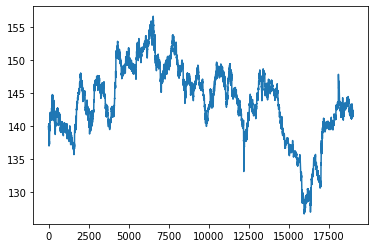

In [2]:
# データの読み込み
stock_data = pd.read_csv("../00.data/GBPJPY.60_api.csv", encoding="shift-jis")
# 読み込みデータの表示
#stock_data.head()
raw_data = np.array(stock_data["close"])
plt.plot(raw_data)
plt.show()

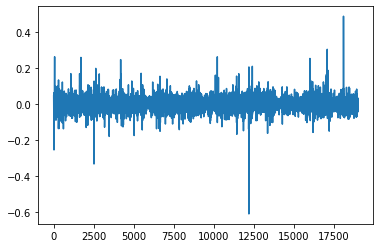

In [3]:
# 正規化、おおよそ-1.0-1.0の範囲に収まるように調整
count=len(raw_data)

std_data = []
for i in range(1, count):
    std_data.append(float(raw_data[i] - raw_data[i-1])/float(raw_data[i-1]) * 20)
    
plt.plot(std_data)
plt.show()

In [4]:
# データサイスが80
# 入力データが80サイズで収まる個数
size= (count//80-1)*80
print(count,size)

18998 18880


次に、実験における入力と出力を決める必要があります。  
今回はこれくらいなら実用性がありそう、という目論見を持って、

「連続した64個の時系列データを元に、次の16個の時系列データを生成する」

と言う機械を作りましょう。  
すると、入力と出力は次のように形成すると良いと思います。

In [5]:
# 前処理
input_data = []
output_data = []

for n in range(size):
    # 64個
    input_data.append(std_data[n:n+64])
    # 16個
    output_data.append(std_data[n+64:n+80])

input_data = np.array(input_data)
output_data = np.array(output_data)
print(input_data.shape)
print(output_data.shape)
#plt.plot(output_data)
#plt.show()

(18880, 64)
(18880, 16)


入力と出力のデータが作れましたが、これではまだ十分ではあありません。  
一次元畳み込みでは、データの形状に注意する必要があります。  
一次元畳み込みそうにおける入力の形状(shape)は(<シーケンス長>, <パラメータ数>)となっていなければなりません。  
今回、グラフを作るためのパラメータの個数、つまり、f(t)f(t)は一次元なので、パラメータ数は1となります。  
シーケンス長はサンプルとして取ってくる連続したデータ点の個数となりますので、今回は64となります。  

ということで、入力データをちゃんと扱える形に整形します。

In [6]:
train_X = np.reshape(input_data, (-1, 64, 1))
train_Y = np.reshape(output_data, (-1, 16, 1))
print(train_X.shape)
print(train_Y.shape)

(18880, 64, 1)
(18880, 16, 1)


## 学習器を作る
それでは、学習器を構成する層を積んでみましょう。

In [7]:
model = Sequential()
model.add(Conv1D(64, 8, padding='same', input_shape=(64, 1), activation='relu'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(64, 8, padding='same', activation='relu'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(32, 8, padding='same', activation='relu'))
model.add(Conv1D(1, 8, padding='same', activation='tanh'))

model.compile(loss='mse', optimizer='adam')

ここでConv1D(filters, kernel_size)が一次元畳み込みを表すそうになります。  
Conv1Dの出力層のshapeは (<シーケンス長>, filters)となります。  
なので、一番はじめの層を見ると、先に設定した入力は
(64, 1) -> (64, 64)というshapeになることがわかります。  
また、MaxPooling1Dを使用することで、シーケンス長の部分の次元削減を行います。  
最後の層が出力層ですが、ここで今回予測したい出力と次元があうようにしています。  

積んだ層がどのようになっているかはsummaryを出すことで確認できます。

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 64, 64)            576       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 64)            32832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 32)            16416     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 16, 1)             257       
Total params: 50,081
Trainable params: 50,081
Non-trainable params: 0
__________________________________________________

最後の層の出力が期待値として設定した出力の形状と同じなので、今回は全結合しなくて良い感じです。  
それでは学習を開始しましょう。

In [9]:
# Early-stopping
early_stopping = EarlyStopping(patience=0, verbose=1)
# モデルの訓練
history = model.fit(train_X, train_Y,validation_split=0.1,epochs=epochs,callbacks=[early_stopping])

Train on 16992 samples, validate on 1888 samples
Epoch 1/100
16992/16992 [==============================] - 3s 199us/step - loss: 6.4696e-04 - val_loss: 6.7393e-04
Epoch 2/100
16992/16992 [==============================] - 3s 191us/step - loss: 6.4670e-04 - val_loss: 6.7381e-04
Epoch 3/100
16992/16992 [==============================] - 3s 194us/step - loss: 6.4633e-04 - val_loss: 6.7436e-04
Epoch 00003: early stopping


全データの内、10%をテストデータとして確保することにしました。
また、学習過程をhistoryに保存しているので、こいつを表示して学習の収束具合を調べてみましょう。

適当に nb_epoch を決めて固定の回数だけ訓練ループを回していたが過学習の危険がある。  
loss（訓練データの損失）と val_loss（バリデーションセットの損失）をプロットする  
loss はエポックが経つにつれてどんどん下がるが、逆に val_loss が上がっていくことがわかる。  
これは、訓練データセットに過剰にフィットしてしまうために未知のデータセットに対する予測性能が下がってしまう過学習を起こしていることを意味する。  
機械学習の目的は未知のデータセットに対する予測性能を上げることなので過学習はダメ！

普通は訓練ループを回すほど性能が上がりそうだけど、先に見たように訓練ループを回せば回すほど性能が悪化する場合がある。  
そのため、予測性能が下がる前にループを打ち切りたい。  
val_loss をプロットして目視でどこで打ち切るか判断することもできるが、それを自動で判断してくれるのがEarly-stoppingというアルゴリズム。

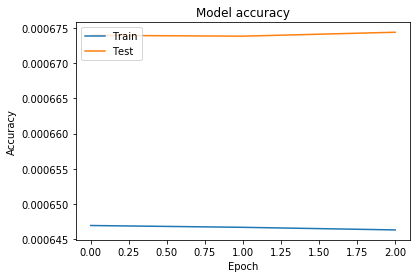

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 学習器を使用してみる
学習しただけでは意味がありませんので、軽く使用してみましょう。  
今回作ったのは、前の64点から次の16点を導き出す機械ですので、はじめに64点のサンプルを取り出し、それを使って16点を生成したら、その16点を新たにサンプルに加えて、次の16点を生成する・・・を繰り返すジェネレータを作ってみましょう。  
今回は20回分、320点先まで予測させてみましょう。

In [70]:
start = 100
sheed = np.reshape(std_data[start:start+64], (1, 64, 1))
prediction = sheed

for i in range(20):
    res = model.predict(sheed)
    sheed = np.concatenate((sheed[:, 16:, :], res), axis=1)
    prediction = np.concatenate((prediction, res), axis=1)

次に、予測結果predictionと元のデータを比較しましょう。  
グラフに書き出しやすいように、少々データを整形しています。

(1, 384, 1)
(384,)


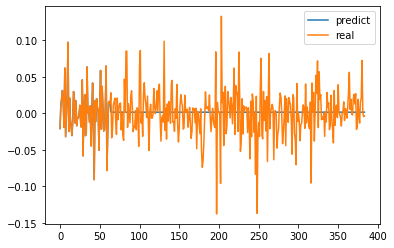

In [71]:
print(prediction.shape)
predictor = np.reshape(prediction, (-1))
print(predictor.shape)
plt.plot(range(len(predictor)), predictor, label='predict')
plt.plot(range(len(predictor)), std_data[start:start + len(predictor)], label='real')
plt.legend() 
plt.show()